# Explaining a Linear model

Wait, wait! The linear model is explainably by design, why do we need to explain it? 
Well, although there is a debate on whether linear models are explainable or not, for the sake of this tutorial, we will assume they really are.
Therefore, we will employ a linear model to demonstrate the various feature effect methods contained within the 'Effector' package, with the goal of gaining an intuitive understanding of the results.

In [1]:
import numpy as np
import effector
import importlib

## Generate a toy dataset

We will generate $N=1000$ examples with 3 features each. The features are defined as follows:

- $x_1$: a linearly spaced feature between $0$ and $1$, i.e., $x_1 \sim \mathcal{U}(0,1)$
- $x_2$: a normally distributed feature with mean $x_1$ and standard deviation of $0.01$, i.e., $x_2 \sim \mathcal{N}(x_1, 0.01)$
- $x_3$: a normally distributed feature with mean $0$ and standard deviation of $1$, i.e., $x_3 \sim \mathcal{N}(0, 1)$


In [2]:
def generate_dataset(N, x1_min, x1_max, x2_sigma, x3_sigma):
    x1 = np.concatenate((np.array([x1_min]),
                         np.random.uniform(x1_min, x1_max, size=int(N - 2)),
                         np.array([x1_max])))
    x2 = np.random.normal(loc=x1, scale=x2_sigma)
    x3 = np.random.normal(loc=np.zeros_like(x1), scale=x3_sigma)
    return np.stack((x1, x2, x3), axis=-1)


In [3]:
np.random.seed(21)

N = 1000
x1_min = 0
x1_max = 1
x2_sigma = .01
x3_sigma = 1.

X = generate_dataset(N, x1_min, x1_max, x2_sigma, x3_sigma)

## Define the model

As mentioned above, we will use a linear model to demonstrate the various feature effect methods:

$$
y = 7x_1 - 3x_2 + 4x_3
$$

In linear models, it is trivial to compute the (ground-truth) effect of each feature; the effect of $x_i$ is simply $\alpha_i x_i$; the effect of $x_1$ is $7x_1$, of $x_2$ is $-3x_2$, and of $x_3$ is $4x_3$.

Therefore, we can cross-check that the feature effect methods are working correctly by comparing the results to the above values.

Since some methods require the gradient of the model, we will also define the gradient of the model.

In [4]:
def predict(x):
    y = 7*x[:, 0] - 3*x[:, 1] + 4*x[:, 2]
    return y

def predict_grad(x):
    df_dx1 = 7 * np.ones([x.shape[0]])
    df_dx2 = -3 * np.ones([x.shape[0]])
    df_dx3 = 4 * np.ones([x.shape[0]])
    return np.stack([df_dx1, df_dx2, df_dx3], axis=-1)

## Partial Dependence Plot (PDP)

The partial dependence plot (PDP) is a method for visualizing the effect of a feature on the model's prediction.
The PDP is defined as the average of the model's prediction over the entire dataset, while varying the feature of interest:

$$
\text{PDP}(x_i) = \frac{1}{N} \sum_{j=1}^N \hat{y}(x^{(j)}_1, \dots, x_i, \dots, x^{(j)}_D)
$$

where $\hat{y}$ is the model's prediction, $x_{j,i}$ is the $i$-th feature of the $j$-th example, and $D$ is the number of features.

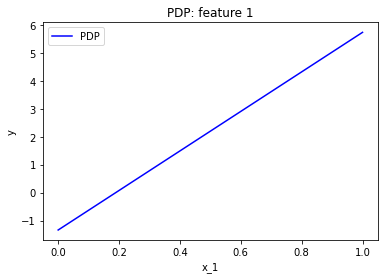

In [11]:
fig, ax = effector.PDP(data=X, model=predict).plot(feature=0)

We can also centerize the PDP plot around the mean of the model's prediction, i.e., $\text{PDP}(x_i) - \frac{1}{N} \sum_{j=1}^N \hat{y}(x^{(j)}_1, \dots, x^{(j)}_D)$.

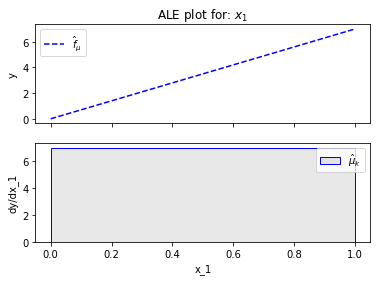

In [6]:
effector.RHALE(data=X, model=predict, model_jac=predict_grad).plot(feature=0)

### Let's take a further step into effector API

As you can see, above the two plots are not identical; PDP plot starts from $y=-1$ and stop at $y=6$, whereas RHALE starts goes from $y=0$ to $y=7$.
With a more carefull view, we can see that this is only a mater of shift at the y axis and both lines have the same slope.

`Effector` provides a set of parameters to configure such details. For example, setting `centering=True` will make both plots look identical

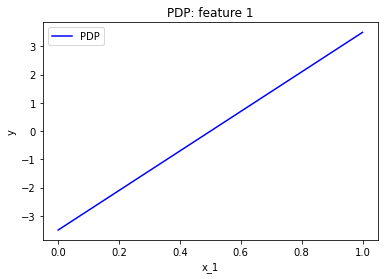

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:title={'center':'PDP: feature 1'}, xlabel='x_1', ylabel='y'>)

In [7]:
effector.PDP(data=X, model=predict).plot(feature=0, centering=True)

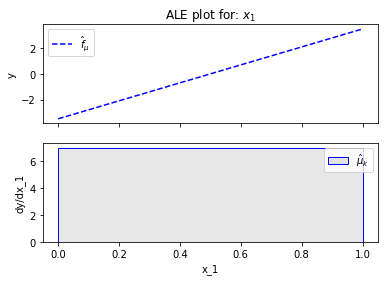

In [8]:
effector.RHALE(data=X, model=predict, model_jac=predict_grad).plot(feature=0, centering=True)

# Define a model with interactions

In [9]:
def predict(x):
    y = 7*x[:, 0] - 3*x[:, 1] + 4*x[:, 2] + 2*x[:, 0]*x[:, 2]
    return y

def predict_grad(x):
    df_dx1 = 7 + 2*x[:, 2]
    df_dx2 = -3 * np.ones([x.shape[0]])
    df_dx3 = 4 * np.ones([x.shape[0]]) + 2*x[:, 0]
    return np.stack([df_dx1, df_dx2, df_dx3], axis=-1)

### PDP and ICE

In [10]:
effector.PDP(data=X, model=predict).plot(feature=0, centering=True, uncertainty=True)

TypeError: plot() got an unexpected keyword argument 'uncertainty'

In [ ]:
effector.RHALE(data=X, model=predict, model_jac=predict_grad).plot(feature=0, uncertainty=True)

In [ ]:
rhale = effector.RHALE(data=X, model=predict, model_jac=predict_grad)
rhale.fit(features="all")
rhale.plot(feature=2, centering=True, uncertainty=True)

In [ ]:
### ICE
effector = importlib.reload(effector)
pdp_ice = effector.PDPwithICE(data=X, model=predict)
pdp_ice.fit(features="all")
# pdp_ice.eval(x=np.array([[0.5, 0.5, 0.5]]))
pdp_ice.plot(feature=0, centering=True)

In [ ]:
pdp_ice.data[:, 0].max()

In [ ]:
pdp_ice.axis_limits

In [ ]:
pdp_ice.y_ice[2].plot(feature=0, centering=True)

In [ ]:
pdp_ice.y_ice[2].data

In [ ]:
pdp_ice.y_ice[2].eval(feature=0, xs=np.array([0.0, 0.1, 0.2, 0.3]))